# Theory $\rightarrow$ Python

## Turtlebot

In [1]:
import pykal

In [2]:
import numpy as np
from numpy.typing import NDArray

def f_tb(pose:NDArray, uk:NDArray) -> NDArray:
    _,_,th = float(pose[0]),float(pose[1]),float(pose[2])
    v,w = float(uk[0]), float(uk[1])

    xdot, ydot, thdot = v * np.cos(th), v * np.sin(th), w
    xkdot = np.atleast_2d([xdot,ydot,thdot])

    return xkdot.T

def F(pose, uk, dt=0.1):
    xk, yk, thk = pose
    v, w = uk
    return np.array([
        xk + dt * v * np.cos(thk),
        yk + dt * v * np.sin(thk),
        thk + dt * w
    ])

def h_tb(pose:NDArray):
    return pose

turtlebot_block = pykal.DynamicalSystem(f = F, h= h_tb,state_name="pose") 
turtlebot_block.__dict__


{'_f': <function __main__.F(pose, uk, dt=0.1)>,
 '_h': <function __main__.h_tb(pose: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]])>,
 '_state_name': 'pose'}

## KF

We implement the Kalman Filter (KF)  as a discrete-time dynamical system. This KF has its own internal **kf state** consisting of the estimated state of the turtlebot $\hat{\mathbf{x}}_{\text{turtle}}$ and the error covariance $P$:

$$
\mathbf{x}_{\text{kf}} =
\begin{bmatrix}
\hat{\mathbf{x}}_{\text{turtle}} \\
P
\end{bmatrix}.
$$

The dynamics evolve in discrete time according to the map

$$
\mathbf{x}_{k+1} = f_{\text{kf}}(\mathbf{x}_k, \mathbf{u}_k, \mathbf{y}_{k+1}, \text{dt},f_{\text{tb}},F_{\text{tb}},h_{\text{tb}},H_{\text{tb}}, Q_{\text{tb}},R_{\text{tb}},\text{systype}_{\text{tb}}),
$$

The output function simply extracts the estimated state of the turtlebot ie.

$$
\mathbf{y}_{kf}(\mathbf{x}_{\text{kf}} ) = \hat{\mathbf{x}}_{\text{turtle}}.
$$


In [3]:
from pykal.utilities.estimators.kf import KF
kf_block = pykal.DynamicalSystem(f=KF.f,h=KF.h,state_name="xhat_P")
kf_block.__dict__

{'_f': <function pykal.utilities.estimators.kf.KF.f(xhat_P: Tuple[numpy.ndarray[tuple[Any, ...], numpy.dtype[~_ScalarT]], numpy.ndarray[tuple[Any, ...], numpy.dtype[~_ScalarT]]], *, yk: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]], f: Callable, f_params: Dict, F: Callable, F_params: Dict, Q: Callable, Q_params: Dict, h: Callable, h_params: Dict, H: Callable, H_params: Dict, R: Callable, R_params: Dict) -> Tuple[numpy.ndarray[tuple[Any, ...], numpy.dtype[~_ScalarT]], numpy.ndarray[tuple[Any, ...], numpy.dtype[~_ScalarT]]]>,
 '_h': <function pykal.utilities.estimators.kf.KF.h(xhat_P: Tuple[numpy.ndarray[tuple[Any, ...], numpy.dtype[~_ScalarT]], numpy.ndarray[tuple[Any, ...], numpy.dtype[~_ScalarT]]]) -> numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]]>,
 '_state_name': 'xhat_P'}

## Signal Block

Nothing to see here, folks. Just a humble $h$ function that generates a signal over time. What kind of signal? Perhaps we'll see later

In [4]:
from pykal.utilities.demo import straight_loop_straight
# if f is not initialized, it defaults to the zero dynamics
signal_block = pykal.DynamicalSystem(h=straight_loop_straight) 
signal_block.__dict__

{'_f': None,
 '_h': <function pykal.utilities.demo.straight_loop_straight(tk: float) -> numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]]>,
 '_state_name': None}

## Simulating General Dynamical Systems in Python

In [ ]:
### Simulation Time

dt = 0.1                    # time step of simulation
t_span = np.arange(0,40,dt) # time span of simulation

### Initial Conditions 
 
# turtlebot
xk_tur = np.asarray([0,0,0]) # at origin, facing +x direction

# kf
Pk = np.array([[0.1, 0, 0],
               [0, 0.1, 0],
               [0, 0, 0.1]], dtype=float)
xk_kf = [xk_tur,Pk]

### Initialize State Memory
kf_hist = [xk_kf]
turt_hist = [xk_tur] 
turt_meas_hist = [xk_tur]
### Random Seed
rng = np.random.default_rng(42)

### Jacobians for kf block
def F_tb(pose: NDArray, uk: NDArray, dt: float) -> NDArray:
    v = float(uk[0])
    th = float(pose[2])
    return np.array([[1,0,-dt*v*np.sin(th)],
                     [0,1, dt*v*np.cos(th)],
                     [0,0, 1]])

def H_tb(pose:NDArray):
    return np.eye(pose.shape[0])

def Q_tb(pose:NDArray):
    return np.eye(pose.shape[0]) * 0.001

def R_tb(pose:NDArray):
    return np.eye(pose.shape[0]) * 0.001

### Simulation
for tk in t_span:
    # kinematic model input
    uk = signal_block.step(param_dict={"tk":tk})
    xk_tur,yk_tur = turtlebot_block.step(return_state=True,param_dict={"pose":xk_tur,"uk":uk})
    xk_kf, yk_kf = kf_block.step(return_state=True,param_dict={"xhat_P":xk_kf,"yk":yk_tur,
                                             "f": turtlebot_block.f,"f_params":{"pose":xk_tur,"uk":uk,},
                                             "h": turtlebot_block.h, "h_params":{"pose":xk_tur},
                                             "F": F_tb,"F_params":{"pose":xk_tur,"uk":uk,"dt":dt},
                                             "H": H_tb,"H_params":{"pose":xk_tur},                                             
                                             "Q": Q_tb,"Q_params":{"pose":xk_tur},
                                             "R": R_tb,"R_params":{"pose":xk_tur},                                                                                                  
                                             },
                                             )
    turt_hist.append(xk_tur.T)
    turt_meas_hist.append(yk_tur.T)
    kf_hist.append(xk_kf)


/tmp/ipykernel_92422/2652546901.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = float(uk[0])
/tmp/ipykernel_92422/2652546901.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th = float(pose[2])


<Axes: title={'center': '2D Trajectory measurements'}, xlabel='x', ylabel='y'>

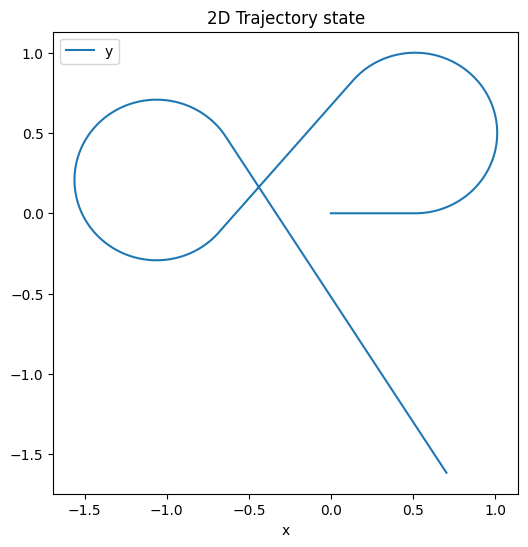

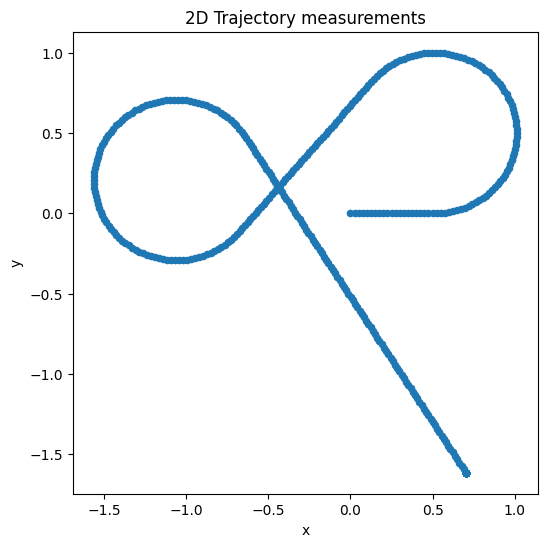

In [6]:
import pandas as pd
Xdf = pd.DataFrame(np.vstack(turt_hist),columns=["x", "y", "theta"])
Ydf = pd.DataFrame(np.vstack(turt_meas_hist),columns=["x", "y", "theta"])
Xdf.plot(x="x", y="y", kind="line", figsize=(6, 6), title="2D Trajectory state")
Ydf.plot(x="x", y="y", kind="scatter", figsize=(6, 6), title="2D Trajectory measurements")


In [7]:
kf_hist[34]

(array([[0.84410226],
        [0.12560713],
        [0.75      ]]),
 array([[ 6.18060820e-04, -3.28497310e-08, -1.68220282e-06],
        [-3.28497310e-08,  6.18074278e-04,  2.03212066e-06],
        [-1.68220282e-06,  2.03212066e-06,  6.18012653e-04]]))

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# ----- helpers -----
def _as_flat(v):
    a = np.asarray(v)
    return a.reshape(-1)

def cov_ellipse_params(Pxy, nsig=3.0):
    """
    From 2x2 covariance Pxy, return (width, height, angle_deg) for a Matplotlib Ellipse.
    width/height are full diameters (not radii), already scaled by nsig.
    """
    # Eigen-decomposition (symmetric matrix -> real eigs)
    vals, vecs = np.linalg.eigh(Pxy)
    # Sort by descending variance
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Major/minor axis lengths (radii): nsig * sqrt(eigenvalues)
    # Ellipse expects full width/height (diameters)
    width  = 2.0 * nsig * np.sqrt(max(vals[0], 0.0))
    height = 2.0 * nsig * np.sqrt(max(vals[1], 0.0))

    # Angle of major axis (eigvec for largest eigenvalue)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return width, height, angle

# ----- materialize arrays -----
# True states (T_true, 3)
Y_true = np.vstack([_as_flat(y) for y in kf_hist])
T_true = Y_true.shape[0]

# EKF estimates
x_est = np.vstack([_as_flat(xhat) for (xhat, _) in kf_block.X])  # (T_est, n)
P_est = np.stack([Pk for (_, Pk) in kf_block.X])                 # (T_est, n, n)
T_est = x_est.shape[0]

# ----- align lengths -----
# Common case: you may have stored an initial EKF state at t=0 (making T_est = T_true or T_true+1)
if T_est == T_true + 1:
    x_est_plot = x_est[:-1]
    P_est_plot = P_est[:-1]
    T_plot = T_true
else:
    T_plot = min(T_true, T_est)
    x_est_plot = x_est[:T_plot]
    P_est_plot = P_est[:T_plot]
Y_true_plot = Y_true[:T_plot]

# ----- indices for position in state vector -----
# Change this tuple if your state order differs.
ix, iy = 0, 1

# ----- plot -----
fig, ax = plt.subplots(figsize=(6, 6))

# True path
ax.plot(Y_true_plot[:, ix], Y_true_plot[:, iy], '*',label="true path", lw=2)

# Estimated path (mean)
ax.plot(x_est_plot[:, ix], x_est_plot[:, iy], '--', label="KF est", lw=2)

# Covariance ellipses (every k steps to avoid clutter)
stride = max(1, T_plot // 40)  # ~40 ellipses max; adjust to taste
nsig = 3.0
for t in range(0, T_plot, stride):
    Px = P_est_plot[t]
    Pxy = Px[np.ix_([ix, iy], [ix, iy])]   # 2x2 subcovariance for (x,y)
    w, h, ang = cov_ellipse_params(Pxy, nsig=nsig)
    e = Ellipse(
        xy=(x_est_plot[t, ix], x_est_plot[t, iy]),
        width=w, height=h, angle=ang,
        edgecolor='C1', facecolor='C1', alpha=0.2, lw=1
    )
    ax.add_patch(e)

ax.set_aspect('equal', adjustable='box')
ax.set_title(f"2D Trajectory with {nsig}σ KF Covariance")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3) + inhomogeneous part.

# Python $\rightarrow$ ROS

Having confirmed our kf works, we want to create a ROS node that will allow our kf algorithm to interface with actual sensor data and input data from a running Turtlebot. We do this by creating a wrapper that takes in time and an input dictionary and then runs the code *we've already tested* in **Simulating General Dynamical Systems**.

In [24]:
import numpy as np
from numpy.typing import NDArray
from collections import deque
kf_hist = deque(maxlen=5)

def callback(tk, **inputs):
    yk = inputs.get("yk", None)
    uk = inputs.get("uk", None)
    dt = 1 / 60 # 60 Hz


    # If inputs aren’t ready yet, do nothing.
    if yk is None or uk is None:
        return {}
    
    xk_kf = kf_hist[-1]
    xk_kf, yk_kf = kf_block.step(return_state=True,param_dict={"xhat_P":xk_kf,"yk":yk,
                                             "f": turtlebot_block.f,"f_params":{"pose":yk,"uk":uk,},
                                             "h": turtlebot_block.h, "h_params":{"pose":yk},
                                             "F": F_tb,"F_params":{"pose":yk,"uk":uk,"dt":dt},
                                             "H": H_tb,"H_params":{"pose":yk},                                             
                                             "Q": Q_tb,"Q_params":{"pose":yk},
                                             "R": R_tb,"R_params":{"pose":yk},                                                                                                  
                                             },
                                             )
    kf_hist.append(xk_kf)
    return {"pose_kf": yk_kf}

In [29]:
history = []
### Simulation
for tk in t_span:
    # kinematic model input
    uk = signal_block.step(param_dict={"tk":tk})
    xk_tur,yk_tur = turtlebot_block.step(return_state=True,param_dict={"pose":xk_tur,"uk":uk})
    history.append(callback(tk,**{"uk":uk,"yk":yk_tur}))

/tmp/ipykernel_92422/2652546901.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = float(uk[0])
/tmp/ipykernel_92422/2652546901.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th = float(pose[2])


In [30]:
history

[{'pose_kf': array([[ 0.75546559],
         [-1.65773761],
         [-1.        ]])},
 {'pose_kf': array([[ 0.76897315],
         [-1.67877438],
         [-1.        ]])},
 {'pose_kf': array([[ 0.7824807 ],
         [-1.69981115],
         [-1.        ]])},
 {'pose_kf': array([[ 0.79598826],
         [-1.72084793],
         [-1.        ]])},
 {'pose_kf': array([[ 0.80949582],
         [-1.7418847 ],
         [-1.        ]])},
 {'pose_kf': array([[ 0.82300338],
         [-1.76292148],
         [-1.        ]])},
 {'pose_kf': array([[ 0.83651093],
         [-1.78395825],
         [-1.        ]])},
 {'pose_kf': array([[ 0.85001849],
         [-1.80499503],
         [-1.        ]])},
 {'pose_kf': array([[ 0.86352605],
         [-1.8260318 ],
         [-1.        ]])},
 {'pose_kf': array([[ 0.87703361],
         [-1.84706858],
         [-1.        ]])},
 {'pose_kf': array([[ 0.89054117],
         [-1.86810535],
         [-1.        ]])},
 {'pose_kf': array([[ 0.90404872],
         [-1.889142

## Initialize rclpy
rclpy.init() boots the ROS 2 client library in this Python process: it sets up middleware, parameters, logging, and the event loop plumbing that our node will use.

In [16]:
import rclpy
rclpy.init()

RuntimeError: Context.init() must only be called once

## Initialize the Node
We create a BlockROSNode that wraps our already-tested KF function so it can subscribe to real topics and publish estimates
This keeps a clean separation of concerns: ROS I/O in BlockROSNode, estimation logic in wrapper/DSBlock.

In [26]:
from turtlesim.msg import Pose
from geometry_msgs.msg import Twist         # Import standard velocity command message (linear + angular components)
# Initialize the wrapper with initial KF state
xk_tur = np.asarray([0,0,0]) # at origin, facing +x direction

# kf
Pk = np.array([[0.1, 0, 0],
               [0, 0.1, 0],
               [0, 0, 0.1]], dtype=float)

kf_hist= [] # clear state from previous trials
kf_hist.append([xk_tur,Pk])

kf_node = pykal.ROSNode(
    node_name="kf",
    callback=callback,
    subscribes_to=[
        ("/turtle1/pose",Pose,  "yk"),
        ("/turtle1/cmd_vel", Twist, "uk"), 
    ],
    publishes_to=[
        ("pose_kf", Pose, "/turtle1/pose_hat"), 
    ],
    rate_hz=60.0,
    stale_config={
        "uk": {"after": 1.0, "policy": "zero"},  # zero cmd after 1s silence (like turtlesim)
    })

In [25]:
kf_node.destroy()

In [ ]:
callback

[[array([5.54444456, 5.54444456, 0.        ]),
  array([[0.1, 0. , 0. ],
         [0. , 0.1, 0. ],
         [0. , 0. , 0.1]])]]

In [23]:
kf_node.stop()

We represent the **turtlebot block** as a dynamical system. The plant state vector $\mathbf{x}$ and input vector $\mathbf{u}$ are given by

$$
\mathbf{x} =
\begin{bmatrix}
x \\ 
y \\
\theta
\end{bmatrix},
\qquad  
\mathbf{u} =
\begin{bmatrix}
v \\ 
\omega
\end{bmatrix}.
$$

where  
- $x$ is the horizontal component of position,  
- $y$ is the vertical component of position,  
- $\theta$ is the angular displacement of the turtlebot heading w.r.t. the $+x$ axis (positive counterclockwise).  

and  
- $v$ is the commanded linear velocity,  
- $\omega$ is the commanded angular velocity.  

The turtlebot follows the standard unicycle kinematic model, so the dynamics are

$$
\dot{\mathbf{x}} = f(\mathbf{x}, \mathbf{u}) =
\begin{bmatrix}
v \cos\theta \\ 
v \sin\theta \\
\omega
\end{bmatrix}.
$$

We define the output function as the identity map, i.e.,

$$
\mathbf{y} = h(\mathbf{x}) = \mathbf{x}.
$$

Thus, the dynamical system is

$$
\dot{\mathbf{x}} = f(\mathbf{x}, \mathbf{u}) =
\begin{bmatrix}
v \cos\theta \\ 
v \sin\theta \\
\omega
\end{bmatrix},
\qquad
\mathbf{y} = h(\mathbf{x}) = \mathbf{x}.
$$

## Spin Node

In [18]:
kf_node.start()

[ROSBlock] started node='kf' pub=['/turtle1/pose_hat'] sub=['/turtle1/pose', '/turtle1/cmd_vel'] @ 60.0 Hz


## Destroy Node

In [19]:
kf_node.stop()

[ROSBlock] stopped.


# Plot Data from Experiment

In [39]:
kf_block.X

AttributeError: 'DynamicalSystem' object has no attribute 'X'

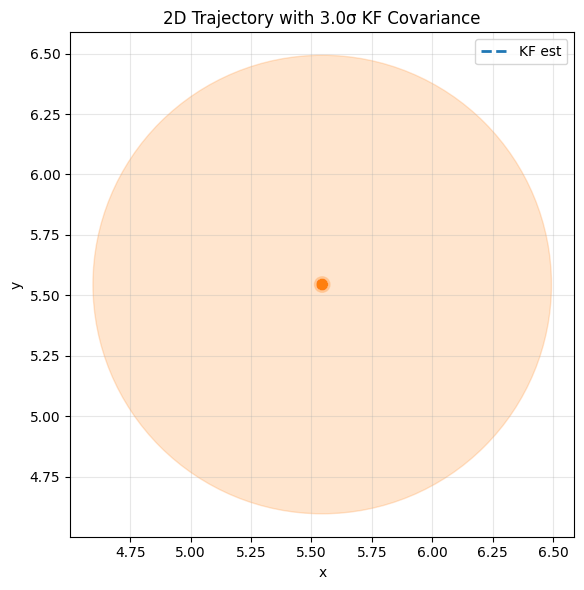

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# ----- helpers -----
def _as_flat(v):
    a = np.asarray(v)
    return a.reshape(-1)

def cov_ellipse_params(Pxy, nsig=3.0):
    """
    From 2x2 covariance Pxy, return (width, height, angle_deg) for a Matplotlib Ellipse.
    width/height are full diameters (not radii), already scaled by nsig.
    """
    # Eigen-decomposition (symmetric matrix -> real eigs)
    vals, vecs = np.linalg.eigh(Pxy)
    # Sort by descending variance
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Major/minor axis lengths (radii): nsig * sqrt(eigenvalues)
    # Ellipse expects full width/height (diameters)
    width  = 2.0 * nsig * np.sqrt(max(vals[0], 0.0))
    height = 2.0 * nsig * np.sqrt(max(vals[1], 0.0))

    # Angle of major axis (eigvec for largest eigenvalue)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return width, height, angle

# ----- materialize arrays -----
# True states (T_true, 3)
Y_true = np.vstack([_as_flat(y) for y in turtlebot_block.Y])
T_true = Y_true.shape[0]

# EKF estimates
x_est = np.vstack([_as_flat(xhat) for (xhat, _) in kf_block.X])  # (T_est, n)
P_est = np.stack([Pk for (_, Pk) in kf_block.X])                 # (T_est, n, n)
T_est = x_est.shape[0]

# ----- align lengths -----
# Common case: you may have stored an initial EKF state at t=0 (making T_est = T_true or T_true+1)
if T_est == T_true + 1:
    x_est_plot = x_est[:-1]
    P_est_plot = P_est[:-1]
    T_plot = T_true
else:
    T_plot = min(T_true, T_est)
    x_est_plot = x_est[:T_plot]
    P_est_plot = P_est[:T_plot]
Y_true_plot = Y_true[:T_plot]

# ----- indices for position in state vector -----
# Change this tuple if your state order differs.
ix, iy = 0, 1

# ----- plot -----
fig, ax = plt.subplots(figsize=(6, 6))

# Estimated path (mean)
ax.plot(x_est_plot[:, ix], x_est_plot[:, iy], '--', label="KF est", lw=2)

# Covariance ellipses (every k steps to avoid clutter)
stride = max(1, T_plot // 40)  # ~40 ellipses max; adjust to taste
nsig = 3.0
for t in range(0, T_plot, stride):
    Px = P_est_plot[t]
    Pxy = Px[np.ix_([ix, iy], [ix, iy])]   # 2x2 subcovariance for (x,y)
    w, h, ang = cov_ellipse_params(Pxy, nsig=nsig)
    e = Ellipse(
        xy=(x_est_plot[t, ix], x_est_plot[t, iy]),
        width=w, height=h, angle=ang,
        edgecolor='C1', facecolor='C1', alpha=0.2, lw=1
    )
    ax.add_patch(e)

ax.set_aspect('equal', adjustable='box')
ax.set_title(f"2D Trajectory with {nsig}σ KF Covariance")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()